# Some key concepts 

## **Background**
- feature engineering and SVM
- conputational speed and GPU
- dataset size and internet, orders of magnitude more data
- Framework such as TF, Keras

**NN as universal approximators**
- More neurons --> more complicated functions
- Regularization to prevent overfitting

## **Activation Function**
- Sigmoid
    * Saturated at 0/1 and kills gradients (derivative -> 0)
    * Output not zero-centred; for next layer: f = wx + b, x>0, df/dw same sign for all w; zig-zag update trajectory
    
    
- Tanh
    * Still kills gradients
    * But: zero-cented
    
    
- ReLU
    * Non-saturated, linearity --> Accelerate convergence
    * Cheap computation
    * But: Can die; never activate
    * Extension: Leaky ReLU, maxout


- Leaky ReLU

<img src="https://cdn-images-1.medium.com/max/1200/1*ZafDv3VUm60Eh10OeJu1vw.png" width="500">


## **Regularization**
- L1/L2/ElasticNet
- Max Norm constraint
- Drop Out layer

## **Hyperparameter Optimization**
- Single validation set > cross validation in practice
- Random search instead of grid search within a range
- Metric selection: accuracy, RMSE, etc.
- Ideally: Training + Validation + Test, where validation set is to *"learn"* hyperparameters. 
    - Think of hyperparam tuning itself a learning algorithm and validation set becomes "training set" in the new problem.


- Important hyperparams:
    - Network structure
    - Batch size
    - Learing rate



## **Weights Initialization**


- **All zero**: 
    - Wrong: neuron outputs and gradients would be same; same update
    - We don't want the symmetric structure of weights
    - The model will be equivalent to linear model since each weight *w* has the same update
    
    
- **Number to small**: 
    - small gradients for hidden layer inputs ($\frac{\partial L}{\partial h} = W$)
    - ***Gradient Vanishing*** when flowing backwafrd, leading to convergence of the cost before it has reached the minimum value.


- **Number to big**: 
    - ***Gradient Exploding*** problem may happen, and cause the cost to oscillate around its minimum value.
    - will also be a problem is activation functions like sigmoid is used since the **WX** may fall into zero-gradient region


- **Preferred: All neuron with a good output distribution to feed next layer**:
    - Benefit: effective back-propagation for weights
    - w = np.random.randn(n) / sqrt(n), where n is number of inputs. In other words, the standard error $std(w) = \sqrt\frac {1}{n}$
    - It can be proved that Var(S) = Var(WX) = Var(X)
    - It helps get a wide range of output value for each hidden layer
    - For activation functions ReLU, see below: $std(w) = \sqrt\frac {2}{n}$

- ***To sum up, the goal is to***:
    - The mean of the activations should be zero.
    - The variance of the activations should stay the same across every layer

- **An example**
    - An example shows how weight initialization helps keep the same distribution of each layer's output.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

node_num = 100    
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return x * (x > 0)

def get_activation(w, activation):
    x = np.random.randn(10000, 100) 
    hidden_layer_size = 5
    activations = {}
    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]
        z = np.dot(x, w)
        if activation == "sigmoid":
            a = sigmoid(z)
        elif activation == "ReLU":
            a = ReLU(z)
        activations[i] = a
    return activations

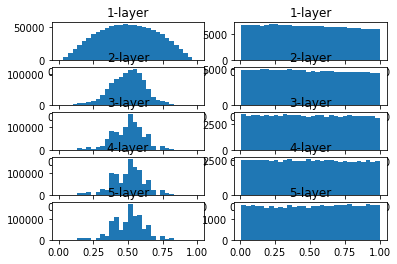

In [8]:
w = np.random.randn(node_num, node_num) * 1 / np.sqrt(node_num)
activations = get_activation(w, 'sigmoid')
for i, a in activations.items():
    plt.subplot(len(activations),2 , 2 * i + 1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
    
w = np.random.randn(node_num, node_num) * 2 / np.sqrt(node_num)
activations = get_activation(w, 'ReLU')    
for i, a in activations.items():
    plt.subplot(len(activations),2 , 2 + 2 * i)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0.01,1))   
    
plt.show()

## **Dropout**

- Reduce interaction/co-adapt between units -> better generalization
- Similar to subsampling/bagging on network model

<img src="./figure/dropout.png" width="500">

- Train:
    - `self.mask = np.random.rand(*self.W.shape) < self.p / self.p`
    - `self.W *= self.mask`

- Test:
    - As usual

## **Batch Normalization**
###  Internal Covariate Shift
- Different layers have different distributions of input data
    
    - 1. Gradient Vanishing: activation function input value within nonlinear regime for sigmoid function <img src="https://image.slidesharecdn.com/dlmmdcud1l06optimization-170427160940/95/optimizing-deep-networks-d1l6-insightdcu-machine-learning-workshop-2017-8-638.jpg?cb=1493309658" width="500">

    - 2. Slow learning: different scale makes it harder for faster convergence using SGD
<img src="https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_folder_5/FeatureScaling.jpg" width="500">


### Algorithm
1. **Shift and scale the output values to $N(0,1)$**
    - <img src="https://guillaumebrg.files.wordpress.com/2016/02/bn.png?w=656" width="500">

    - Improve gradient flow (point1)
    - Allow higher learning rates (point2)
    - Reduce dependence on initialization (output distribution no long depends on weights $W$)
    - *Note*: At test time, the mean from training should be used instead of calculated from testing batch


2. **Learn $\gamma$ and $\beta$ to retrieve representation power**
    - The distribution of the feature may be located at two sides of the non-linear regions for sigmoid funciton, and forcing it to be standardized will lose the distribution.
    
<img src="https://kratzert.github.io/images/bn_backpass/bn_algorithm.PNG" width="400">


<img src="https://qph.fs.quoracdn.net/main-qimg-36a6ee9c550f479fc681eab380510baf" width="500">

<img src="https://forums.fast.ai/uploads/default/original/2X/9/998a1be6463260f731481106756034c42040e256.jpg" width="400">

3. **How to predict**
    - Use the unbiased estimation of mean and variance from all train batches

## **Param Update and Learning Rate**
- Step decay for learning rate: 
    * Reduce the learning rate by some factor every few epochs. 
    * Other approaches also avalable, like exponential decay, 1/t decay, etc.
- Second-order update method:
    * i.e., Newton's method, not common
- Per-parameter adaptive learning rate methods: 
    * For example: Adagrad, Adam

## Gradient Descent

- Batch Gradient Descent: 
    - Global optimal for convex function
    - High use of memory; slow
    
    
- Stochatic Gradient Descent
    - High speed
    - More number of iterations
    - For non-convex funciton, may reach better optimal
    
    
- Mini-batch Gradient Descent
    - Balance between batch and stochatic gradient descent

<img src="https://www.bogotobogo.com/python/scikit-learn/images/Batch-vs-Stochastic-Gradient-Descent/stochastic-vs-batch-gradient-descent.png" width="400">

## Gradient Descent w/o Momentum Update

### Treat all elements of $dX$ as a whole in terms of learning rate

- If gradient direction not changed, increase update, faster convergence
- If gradient direction changed, reduce update, reduce oscillation
- Keep most of accumulated direction, and slightly adjust based on new direction
- <font color="blue">hard to determine learning rate</font>

In [121]:
import numpy as np
def VanillaUpdate(x, dx, learning_rate):
    x += -learning_rate * dx
    return x

def MomentumUpdate(x, dx, v, learning_rate, mu):
    v = mu * v - learning_rate * dx # integrate velocity, mu's typical value is about 0.9
    x += v # integrate position     
    return x, v

<img src="http://cs231n.github.io/assets/nn3/nesterov.jpeg" width="600">

### Treat each element of $dX$ adaptively in terms of learning rate

1. Those dx receiving infrequent updates should have higher learning rate. vice versa. - <font color="blue">AdaGrad</font>
2. We don't want: the gradients accumulate (too aggressive), and the learning rate monotically decrease. Instead, we want: modulates the learning rate of each weight based on the magnitudes of its gradient only within a recent time window (i.e., less weights for past $dX$) - <font color="blue">RMSprop</font>
3. Still want to use "momentum-like" update to get a smooth gradient - <font color="blue">Adam</font>


In [122]:
# 1. AdaGrad
def AdaGrad(x, dx, learning_rate, cache, eps):
    cache += dx**2
    x += - learning_rate * dx / (np.sqrt(cache) + eps) # (usually set somewhere in range from 1e-4 to 1e-8)
    return x, cache
    
# 1+2. RMSprop
def RMSprop(x, dx, learning_rate, cache, eps, decay_rate): #Here, decay_rate typical values are [0.9, 0.99, 0.999]
    cache = decay_rate * cache + (1 - decay_rate) * dx**2
    x += - learning_rate * dx / (np.sqrt(cache) + eps)
    return x, cache
    
# 1+2+3. Adam
def Adam(x, dx, learning_rate, m, v, t, beta1, beta2, eps):
    m = beta1*m + (1-beta1)*dx # Smooth gradient
    #mt = m / (1-beta1**t) # bias-correction step
    v = beta2*v + (1-beta2)*(dx**2) # keep track of past updates
    #vt = v / (1-beta2**t) # bias-correction step
    x += - learning_rate * m / (np.sqrt(v) + eps) # eps = 1e-8, beta1 = 0.9, beta2 = 0.999   
    return x, m, v

<img src="./fig/Optimizers.png" width="600">


## **Second Order Optimization**
- No Hyperparameter and learning rates
- N^2 elements, O(N^3) for taking inverting
- Methods:
    * Quasi-Newton methods(BGFS): O(N^3) -> O(N^2)
    * L-BFGS: Does not form/store the full inverse Hessian.
    
## **Hardware**
- CPU: less cores, faster per core, better at sequential tasks
- GPU: more cores, slower per core, better at parallel tasks (NVIDIA, CUDA, cuDNN)
- TPU: just for DL (Tensor Processing Unit)
    * Split *One* graph over *Multiple* machines

## **Software**
- Caffe (FB)
- PyTorch (FB)
- TF (Google)
- CNTK (MS)
- Dynamic (e.g., Eager Execution) vs. Static (e.g., TF Lower-level API)

# CNN
## Overview

- Characteristics
    - Spatial data like image, video, text, etc.
    - Exploit the local structure of data


- Application
    - Object detection and localization; for example, pedestrian detection for AV, Facebook friends in photo, etc.
    
    - Image Segmentation; obtain boundary of each object in the image 
    
**ConvNets**
- Difference with regular NN:
    * Main difference: each neuron is layer 2 is only connected to a few neurons in layer 1
    * Data arranged in 3 dimensions: height, width, and depth
    
    
- Convolutional Layer:
    * Filter/Kernel (with full depth, but local connectivity across 2d), 3\*3 --> 5\*5
    * The depth of layer 2 == The number of filters in Layer 1
    * `Stride`: usually 1, leaving downsampling to pooling layer. Can use 2 to compromise 1st layer because of computational constraints
    * `Padding`: use same to avoid missing information along the border
    * *Parameter Sharing*: Same weight for filter/kernel at same depth slice in layer 2 (Alternative: local)
    <img src="https://blog.liang2.tw/2015Talk-DeepLearn-CNN/pics/external/cs231n_note_conv_filter.png" width="500">

- Pooling
    * Most common: 2-2 Max Pooling


- Receptive Field
    - For a certain pooling layer, we can find the neurons that contributes most to the activation.
<img src="https://www.researchgate.net/publication/316950618/figure/fig4/AS:495826810007552@1495225731123/The-receptive-field-of-each-convolution-layer-with-a-3-3-kernel-The-green-area-marks.png" width="300">
    
- Fully-Connected Layer


- Common architecture:
    * INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL]\* -> [FC -> RELU]\*2 -> FC
    * Prefer a stack of small filter CONV to one large receptive field CONV layer
    * Stacking three convolutional layers with filters of 3 × 3 and pooling is similar to a single convolutional layer with a 7 × 7 filter.
    
    
- Challenge: Computational resources
<img src="https://i.stack.imgur.com/AuqKy.png" width="500">


- Different features are detected at each layer. For example, AlexNet:
    - More layers can be beneficial for learning complicated features
<img src="https://banner2.kisspng.com/20180607/vcr/kisspng-deep-learning-convolutional-neural-network-alexnet-deep-learning-5b19637f4372c8.8890220615283905272763.jpg" width="600">


**Transfer Learning**
- Apply trained model without last FC layer and use it as feature extracter
- Continue to fine tune the model using smaller learning rate
- Can use different image size


    
## Different architectures
- LeNet-5 (CONV-Subsampling-CONV-Subsampling-FC-FC)
    - Note: sigmoid activation and no Pooling/Dropout layer
    
    
<img src="https://i.stack.imgur.com/tLKYz.png" width="800">

- AlexNet 8 layers (CONV1-MAXPOOL1-NORM1-CONV2-MAXPOOL2-NORM2-CONV3-CONV4-CONV5-MAXPOOL3-FC6-FC7-FC8)
    - Note: ReLU activation and Pooling/Dropout layer
    - Local Response Normalization
    
    
<img src="https://www.safaribooksonline.com/library/view/tensorflow-for-deep/9781491980446/assets/tfdl_0106.png" width="400">

<img src="https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_folder_7/AlexNet_1.jpg" width="300">





- ZFNet (similar with AlexNet)
    * Smaller kernel, more filters




- VGGNet (*smaller* filter and *deeper* networks)
    * 16-19 layers in VGG16Net
    * Three 3 \* 3 kernel with stride == One 7 \* 7 kernel; Same *effective receptive field*
    * ReLU activation function
    * Optimizer: Adam
    * Weight initialization: He
   
    * **deeper network and more non-linearity (more representation power);**
    * **less parameters ( 3 \* 3 \* 3 vs. 7 \* 7)**
<img src="https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_folder_3/CascadingConvolutions.png" width="500">
<img src="http://josephpcohen.com/w/wp-content/uploads/Screen-Shot-2016-01-14-at-11.25.15-AM.png" width="800">



- GoogLeNet
    * Introduced *inception* Module (Parallel filter operations with multiple kernel size)
    * Problem: Output size too big after filter concatenation
    * The purpose of 1 \* 1 convolutonal layer: 
        - Pooling layer keeps the same depth as input
        - 1 \* 1 layer keeps the **same dimension** of input, and **reduces depth** (for example: 64 \* 56 \* 56 after 32 1 \* 1 con --> 32 \* 56 \* 56)
        - Reduce total number of operations
    
<img src="https://www.researchgate.net/profile/Bo_Zhao48/publication/312515254/figure/fig3/AS:489373281067012@1493687090916/nception-module-of-GoogLeNet-This-figure-is-from-the-original-paper-10.jpg" width="400">




- ResNet
    * Use network layers to fit a *Residual mapping* instead of directly fitting a desired underlying mapping
    * Residual blocks are stacked
    * More effective training by enabling gradients to be back-propagated without vanishing
    * Similar to GoogLeNet, can use *bottelneck* layer (1 \* 1 conv layer) for downsampling and efficiency ++
    
<img src="https://www.researchgate.net/profile/Antonio_Theophilo/publication/321347448/figure/fig2/AS:565869411815424@1511925189281/Bottleneck-Blocks-for-ResNet-50-left-identity-shortcut-right-projection-shortcut.png" width="500">

<img src="https://i.stack.imgur.com/kBFIf.png" width="500">

Number of filters for each layer 

|CNN|Convolutional layer filter count progression|
|:-:|:-:|
|LeNet	|20, 50
|AlexNet	|96, 256, 384, 384, 256
|VGGNet|	64, 128, 256, 512, 512

- Data Augmentation
<img src="https://cdn-images-1.medium.com/max/1600/1*dJNlEc7yf93K4pjRJL55PA.png" width="500">

## Transfer Learning

Features:
- Earlier layers: generic visual feature
- Later layers: dataset specific features


Strategy:
- Replace last classifier layer
- Remove classifier (softmax) and FC layer. Use network as a feature extractor
- Use smaller learning rates

# RNN
## Basic RNN and Gradient Vanishing

<img src="http://corochann.com/wp-content/uploads/2017/05/rnn1_graph-800x460.png" width=500>

- What is the problem with RNN
    - <font color = "red">Gradient Vanishing</font> and Exploding with Vanilla RNN
    - Computing gradient of $h_0$ involved many multiplication of ***W*** and ***tanh*** activation (one small gradient would carry over)
    - Brief proof:
    
    $$\frac{ \partial E_t} { \partial w}= \sum_{k=1}^{t}  \frac{ \partial E_t} { \partial y_t}\frac{ \partial y_t} { \partial h_t}\frac{ \partial h_t} { \partial h_k}\frac{ \partial h_k} { \partial w}$$          
    $$\frac{ \partial h_t} { \partial h_k}= \prod_{j= k + 1}^{t} \frac{ \partial h_j} { \partial h_{j-1}}$$
    
    where $$ h_j = tanh(W_{hx}X_j + W_{hh}h_{j-1} + b)$$
    then $$\frac{ \partial h_t} { \partial h_k}= \prod_{j= k + 1}^{t} \frac{ \partial h_j} { \partial h_{j-1}} =  \prod_{j= k + 1}^{t} tanh'(\cdot)W_{hh}$$
    
    note that for tanh function, $tanh'(\cdot)<=1$: <img src="./figure/tanh.png" width="300">

    - Depending on $W_{hh}$, we may have gradient vanish or explode
    - We cannot figure out the dependency between long time interval's data

<img src="./figure/rnn2.png" width="500">  

- How to fix vanishing gradients?
    - Partial fix for gradient exploding: if ||g|| > threshold, shrink value of g
    - Initialize W to be identity
    - Use ReLU as activation function f
    

## Applications of RNN
- Language modelling (see nlp repo for details)
- seq2seq models for machine translations (see nlp repo for details)
- seq2seq with attention (see nlp repo for details)

<img src="https://www.safaribooksonline.com/library/view/tensorflow-for-deep/9781491980446/assets/tfdl_0706.png" width="500">

## LSTM

  
- Main Idea of LSTM
    * **Forget Gate** (\*): how much old memory we want to keep; element-wise multiplication with old memory $ C_{t-1} $. The Parameters are learned as $ W_f $. I.e., $ \sigma(W_f([h_{t-1}, X_t]) + b_f = f_t $. If you want all old memory, then $ f_t $ equals 1. After getting $ f_t $, multiply it with $ C_{t-1} $<br/><br/>
   
    * **New Memory Gate**(\+)
        - How to merge new memory with old memory; piece-wise summation, decides how to combine *new* memory with *old* memory. The weighing parameters are learned as $ W_i $. I.e., $ \sigma(W_i([h_{t-1}, X_t]) + b_i = i_t $. 
    
        - What is the new memory itself: $ tanh(W_C([h_{t-1}, X_t]) + b_C = \tilde{C_t} $
    
        - What is the combined memory: $ C_{t-1} * f_t + \tilde{C_t} * i_t = C_t$ <br/><br/>
        
    * **Output gate**: how much of the new memory we want to output or store? learned solely through combined memory. $ \sigma(W_o([h_{t-1}, X_t]) + b_o = o_t $. Then the final output $ h_t $ would be $ o_t * tanh(C_t) = h_t $
    
    
    
- Why LSTM prevents gradient vanishing?
    - *Linear* Connection between $C_t$ and $C_{t-1}$ rather than multiplying
    - Forget gate controls and keeps long-distance dependency
    - Allows error to flow at different strength based on inputs
    - During initialization: Initialize forget gate bias to one: default to remembering
    - Compared with Vanilla RNN, $\frac{ \partial C_t} { \partial C_k}= \prod_{j= k + 1}^{t} \frac{ \partial C_j} { \partial C_{j-1} }= \prod_{j= k + 1}^{t} \sigma'(\cdot) \approx 0|1$, where $\cdot$ is input to forget gate.
    - Key difference with RNN: we no longer have the term: $\prod_{j= k + 1}^{t} W_{hh}$
    - See proof: https://weberna.github.io/blog/2017/11/15/LSTM-Vanishing-Gradients.html


<img src="https://cdn-images-1.medium.com/max/1600/0*LyfY3Mow9eCYlj7o." width="600">


## Bidirectional LSTM

<img src="https://guillaumegenthial.github.io/assets/bi-lstm.png" width="300">
<img src="https://guillaumegenthial.github.io/assets/char_representation.png" width="300">


## Other variation: Gated Recurrent Unit (GRU)
- **Update Gate**: How to combine old and new state: $ \sigma(W_z([h_{t-1}, X_t])  = z_t $
- **Reset Gate**: How much to keep old state: $ \sigma(W_r([h_{t-1}, X_t])= r_t $
- **New State**: $ tanh(WX_t + r_t * U h_{t-1}) =\tilde{h_t}$ 
- **Combine States**: $z_t* h_{t-1} + (1-z_t) * \tilde{h_t} $
- If r=0, ignore/drop previous state for generating new state
- if z=1, carry information from past through many steps (long-term dependency)

<img src="https://camo.githubusercontent.com/ce3f6d276f10fef2c145daf0fe19c006c92ce019/687474703a2f2f636f6c61682e6769746875622e696f2f706f7374732f323031352d30382d556e6465727374616e64696e672d4c53544d732f696d672f4c53544d332d7661722d4752552e706e67" width="600">

---

<img src="https://www.safaribooksonline.com/library/view/tensorflow-for-deep/9781491980446/assets/tfdl_0705.png" width="500">

## Image Captioning
1. From image: [CONV-POOL] \* n --> FC Layer --> (num_example, 4096) written as **v**
2. Hiddern layer: $h = tanh(W_{xh} * X + W_{hh} * h + W_{ih} * \bf{v} )$
3. Output layer: $y = W_{hy} * h$
4. Get input $ X_{t+1}$ by sampling $\bf{y} $

<img src="https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png" width="500">

<img src="https://www.safaribooksonline.com/library/view/tensorflow-for-deep/9781491980446/assets/tfdl_0108.png" width="500">



# Network Tuning

General Workflow
- Preprocess Data (zero-centered,i.e.,Substract Mean)
- Identify architecture
- Ensure that we can overfit a small traing set to acc = 100%
- Loss not decreasing: too low leaning rate
- Loss goes to NaN: too high learning rate (e.g., log(0) = NaN) 

General guideline:
- Observe training loss and validation loss curve
- Use a subset of data for hyperparameters tuning
- Add shuffling for input data

<img src="https://www.learnopencv.com/wp-content/uploads/2017/11/cnn-keras-curves-without-aug.jpg" width="400">


- Overfitting:
    - Increase Dropout ratio
    - Decrease layers
    - Increase regularization (L1, L2)
    - Early stopping
    - Observe distribution of weights (any extreme values)
    
    
- Underfitting:
    - Increase layers
    - Decrease regularization
    - Decrease learning rate
    

- Gradient vanishing
    - Batch Normalization
    - Less layers
    - Appropriate activation function (Relu instead of Sigmoid)
    
    
- Local minima
    - Increase learning rate
    - Appropriate optimizer
    - Smaller batch size


- Memory concerns
    - What determines memory requirment? 
    - Number of parameters
    - Type of updater (SGD/Momentum/Adam)
    - Mini-batch size
    - Size of single sample
    - Number of activations
    
    
- Learning Rate
    - Observe the relative change of parameters $\frac{\Delta w}{|w|}$ to be around $10^{-3}$.
    - Increase/Decrease the learing rate accordingly
    <img src="https://www.safaribooksonline.com/library/view/deep-learning/9781491924570/assets/dpln_0602.png" width="300">
    - Strategy: start with a relatively large value, and observe if the training process diverges (i.e., training loss increases). And decrease the rate until convergence. Start with values like 0.001.
    
    
- Mini-batch size
    - Biggger Mini-batch gives smoother gradient update but longer to run
    - In practice, 32 to 256 is common for CPU training, and 32 to 1,024 is common for GPU training

- to read: https://pcc.cs.byu.edu/2017/10/02/practical-advice-for-building-deep-neural-networks/

# Scaling

## Hardware
- CPU
- GPU (for parallel)
- TPU (for matrix)

## Parelleling


- Data parallel training splits large datasets across multiple computing nodes
    - Each worker node has a complete copy of the model being trained.
    - One single as supervisor server.
<img src="https://www.safaribooksonline.com/library/view/tensorflow-for-deep/9781491980446/assets/tfdl_0908.png" width="200">


- Model parallel training splits large models across multiple nodes. 
    - Motivation: memory restriction on a single CPU
    - Network itself is stored on multiple CPUs
    - Not common...